# 강좌 리뷰 코멘트를 활용한 교수 평점 예측하기

## 01. 데이터 소개 및 분석프로세스 수립

[지난 프로젝트](https://colab.research.google.com/drive/13dpLXxosZSMcdt4DXOuoxVx1SyjtB949#scrollTo=_bFhocnFBN0l) 에서 리뷰 커뮤니티의 데이터와 교수의 강의 계획서를 활용했을 때 강좌 추천 여부를 얼만큼 잘 분류해 내는지 알아보았습니다.

해당 프로젝트는 데이터내 `수치형 feature`만을 활용해서 추천여부를 분류해보았다면,

이번 프로젝트에서는 `comments`, 학생들이 교수의 강좌를 듣고 남긴 리뷰만을 활용해 해당 강좌의 추천 여부를 분류할 수 있도록 해보겠습니다.

In [1]:
# 한글 깨짐 현상 해결
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm
# from matplotlib import pyplot as plt

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [2]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import re
from collections import defaultdict, Counter

from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import joblib

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
from google.colab import drive

drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [5]:
df = pd.read_csv('/content/MyDrive/MyDrive/RateMyProfessor.csv')
df.head()

,professor_name,school_name,department_name,local_name,state_name,year_since_first_review,star_rating,take_again,diff_index,tag_professor,...,lots_of_homework,accessible_outside_class,lecture_heavy,extra_credit,graded_by_few_things,group_projects,test_heavy,so_many_papers,beware_of_pop_quizzes,IsCourseOnline
0,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
1,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
2,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
3,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
4,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0


### 데이터 탐색 및 전처리

In [6]:
# 데이터 형태
df.shape

(20000, 51)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   professor_name            20000 non-null  object 
 1   school_name               20000 non-null  object 
 2   department_name           20000 non-null  object 
 3   local_name                20000 non-null  object 
 4   state_name                20000 non-null  object 
 5   year_since_first_review   20000 non-null  float64
 6   star_rating               20000 non-null  float64
 7   take_again                2998 non-null   object 
 8   diff_index                20000 non-null  float64
 9   tag_professor             11093 non-null  object 
 10  num_student               20000 non-null  float64
 11  post_date                 19995 non-null  object 
 12  name_onlines              20000 non-null  object 
 13  name_not_onlines          19995 non-null  object 
 14  studen

In [8]:
dtypes_data = df.dtypes.reset_index()
dtypes_data.columns = ['count', 'column type']
dtypes_data = dtypes_data.groupby('column type').aggregate('count').reset_index()
dtypes_data

,column type,count
0,int64,21
1,float64,13
2,object,17


#### 결측값

In [9]:
df.isnull().any().any()

True

In [10]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count', ascending=False)
missing_df

,column_name,missing_count
18,would_take_agains,17418
7,take_again,17002
19,grades,16708
16,attence,15991
17,for_credits,15947
9,tag_professor,8907
22,comments,7
23,word_comment,7
11,post_date,5
13,name_not_onlines,5


In [11]:
def plot_missing_data(df):
  try:
    columns_with_null = df.columns[df.isnull().sum() > 0]
    null_pct = (df[columns_with_null].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(y = null_pct.index, x = null_pct, orient='h', palette='viridis')
    plt.title('데이터 내 Column 별 결측치 비율 (%)', fontsize=16)
  except:
    print('데이터 내 결측치가 없습니다.')

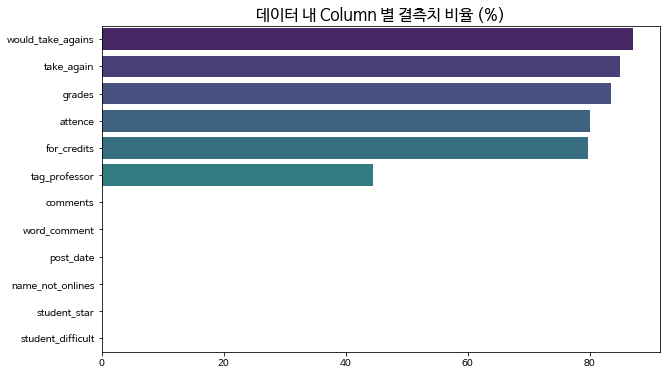

In [12]:
plot_missing_data(df)

이번 프로젝트에서는 `comments` 와 `student_star` 만 활용할 예정이기 때문에 다른 column들에 대한 전처리는 진행하지 않습니다.

같은 데이터로 진행한 이전 [프로젝트](https://colab.research.google.com/drive/13dpLXxosZSMcdt4DXOuoxVx1SyjtB949#scrollTo=8T5NxLYB8hDa)를 참고하시면 다른 column들에 대한 전처리 과정을 확인하실 수 있습니다.

In [13]:
df = df.dropna(subset=['student_star', 'comments'])
df.shape

(19993, 51)

#### 중복값

In [14]:
print('데이터 내 중복된 항목 수:', len(df[df.duplicated()]))

데이터 내 중복된 항목 수: 15


In [15]:
def plot_unique_data(df):
  columns_with_unique = df.columns[df.nunique() > 1]
  unique_pct = (df[columns_with_unique].nunique() / df.shape[0] *100).sort_values(ascending=False)[:10]
  plt.figure(figsize=(10, 6))
  sns.barplot(y = unique_pct.index, x = unique_pct, orient='h', palette='viridis')
  plt.title('데이터 내 Column 별 유니크 값 비율 (%)', fontsize=16)

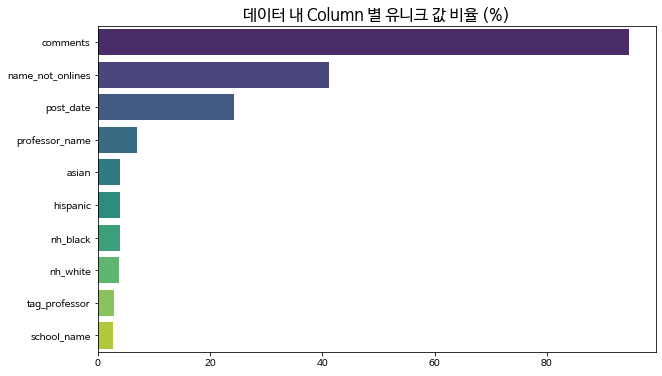

In [16]:
plot_unique_data(df)

In [17]:
df.shape

(19993, 51)

중복 값 제거

In [18]:
df = df.drop_duplicates(keep='first')
df.shape

(19978, 51)

> `comments` feature 내 No comments 로 기입된 데이터는 삭제하겠습니다.

In [19]:
len(df[df['comments'] == 'No Comments'])

966

In [20]:
no_comments = df[df['comments'] == 'No Comments'].index

In [21]:
df = df.drop(no_comments)
df.shape

(19012, 51)

### Target feature 생성

> `student_star`를 활용해 target feature를 생성하겠습니다

2.5 미만인 평점은 비추천, 2.5 이상인 평점은 추천으로 분류하겠습니다


In [22]:
def make_label(x):
  if 1 <= x < 2.5:
    return 0
  else:
    return 1

In [23]:
df['recommended'] = df['student_star'].apply(make_label)
df['recommended'].value_counts()

1    14574
0     4438
Name: recommended, dtype: int64

In [24]:
new_df = df[['comments', 'recommended']].copy()
new_df.head()

,comments,recommended
0,"This class is hard, but its a two-in-one gen-e...",1
1,Definitely going to choose Prof. Looney\'s cla...,1
2,I overall enjoyed this class because the assig...,1
3,"Yes, it\'s possible to get an A but you\'ll de...",1
4,Professor Looney has great knowledge in Astron...,1


In [25]:
new_df['comments'][:5].values

array(['This class is hard, but its a two-in-one gen-ed knockout, and the content is very stimulating. Unlike most classes, you have to actually participate to pass. Sections are easy and offer extra credit every week. Very funny dude. Not much more I can say.',
       "Definitely going to choose Prof. Looney\\'s class again! Interesting class and easy A. You can bring notes to exams so you don\\'t need to remember a lot. Lots of bonus points available and the observatory sessions are awesome!",
       "I overall enjoyed this class because the assignments were straightforward and interesting. I just didn\\'t enjoy the video project because I felt like no one in my group cared enough to help.",
       "Yes, it\\'s possible to get an A but you\\'ll definitely have to work for it. The content is pretty interesting, but you have tog get super organized in this class. You\\'ll have multiple things due every week and a ton lectures to go over. If possible, I\\'d avoid this class as an 8 week

In [26]:
def alphabet_only(string):
    string = re.sub(r'[^a-zA-Z\s]', '', string).lower()
    return string

new_df['comments']=new_df['comments'].apply(lambda x : alphabet_only(x)) 

In [27]:
new_df['comments'][:5].values

array(['this class is hard but its a twoinone gened knockout and the content is very stimulating unlike most classes you have to actually participate to pass sections are easy and offer extra credit every week very funny dude not much more i can say',
       'definitely going to choose prof looneys class again interesting class and easy a you can bring notes to exams so you dont need to remember a lot lots of bonus points available and the observatory sessions are awesome',
       'i overall enjoyed this class because the assignments were straightforward and interesting i just didnt enjoy the video project because i felt like no one in my group cared enough to help',
       'yes its possible to get an a but youll definitely have to work for it the content is pretty interesting but you have tog get super organized in this class youll have multiple things due every week and a ton lectures to go over if possible id avoid this class as an  week course youll definitely always have something

> 두 라벨 공통으로 많이 출현하는 단어는 불용어로 등록해 제거하겠습니다.

In [28]:
stop_words = stopwords.words('english')

new_stopwords = ['class', 'take', 'teacher', 'professor', 'students', 'student', 'like', 'test', 'tests']

stop_words.extend(new_stopwords)

In [29]:
new_df['comments'] = new_df['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [30]:
new_df['comments'][:5].values

array(['hard twoinone gened knockout content stimulating unlike classes actually participate pass sections easy offer extra credit every week funny dude much say',
       'definitely going choose prof looneys interesting easy bring notes exams dont need remember lot lots bonus points available observatory sessions awesome',
       'overall enjoyed assignments straightforward interesting didnt enjoy video project felt one group cared enough help',
       'yes possible get youll definitely work content pretty interesting tog get super organized youll multiple things due every week ton lectures go possible id avoid week course youll definitely always somethingto',
       'looney great knowledge astronomy explain super easy way elementary taught great passion great illustration definitely fun interested knowledge wont cover dont hesitate ask great'],
      dtype=object)

#### Word cloud

두 라벨로 분류된 텍스트들의 특징을 `word cloud`를 활용해 확인해보겠습니다.

In [31]:
new_df['token'] = new_df['comments'].apply(word_tokenize)
new_df.head()

,comments,recommended,token
0,hard twoinone gened knockout content stimulati...,1,"[hard, twoinone, gened, knockout, content, sti..."
1,definitely going choose prof looneys interesti...,1,"[definitely, going, choose, prof, looneys, int..."
2,overall enjoyed assignments straightforward in...,1,"[overall, enjoyed, assignments, straightforwar..."
3,yes possible get youll definitely work content...,1,"[yes, possible, get, youll, definitely, work, ..."
4,looney great knowledge astronomy explain super...,1,"[looney, great, knowledge, astronomy, explain,..."


In [32]:
not_recommended = np.hstack(new_df[new_df.recommended == 0]['token'].values)
recommended = np.hstack(new_df[new_df.recommended == 1]['token'].values)

In [33]:
not_recommended_counts = Counter(not_recommended)
recommended_counts = Counter(recommended)

In [34]:
print(not_recommended_counts.most_common(10))

[('dont', 749), ('doesnt', 641), ('hard', 641), ('ever', 579), ('worst', 538), ('time', 531), ('never', 519), ('get', 509), ('good', 483), ('one', 469)]


> 비추천으로 분류된 리뷰 내 빈도수가 높은 단어

In [35]:
tags = not_recommended_counts.most_common(100)
tags[:10]

[('dont', 749),
 ('doesnt', 641),
 ('hard', 641),
 ('ever', 579),
 ('worst', 538),
 ('time', 531),
 ('never', 519),
 ('get', 509),
 ('good', 483),
 ('one', 469)]

In [36]:
wordcloud = WordCloud(font_path="/content/MyDrive/MyDrive/BMEULJIROTTF.ttf",
                     background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(tags))

> 추천으로 분류된 리뷰 내 빈도수가 높은 단어

In [37]:
tags1 = recommended_counts.most_common(100)
tags1[:10]

[('great', 3264),
 ('easy', 3162),
 ('really', 2936),
 ('good', 2514),
 ('hard', 1960),
 ('get', 1889),
 ('best', 1874),
 ('lot', 1855),
 ('hes', 1816),
 ('work', 1793)]

In [38]:
wordcloud1 = WordCloud(font_path="/content/MyDrive/MyDrive/BMEULJIROTTF.ttf",
                     background_color='white',width=800, height=600)
cloud1 = wordcloud1.generate_from_frequencies(dict(tags1))

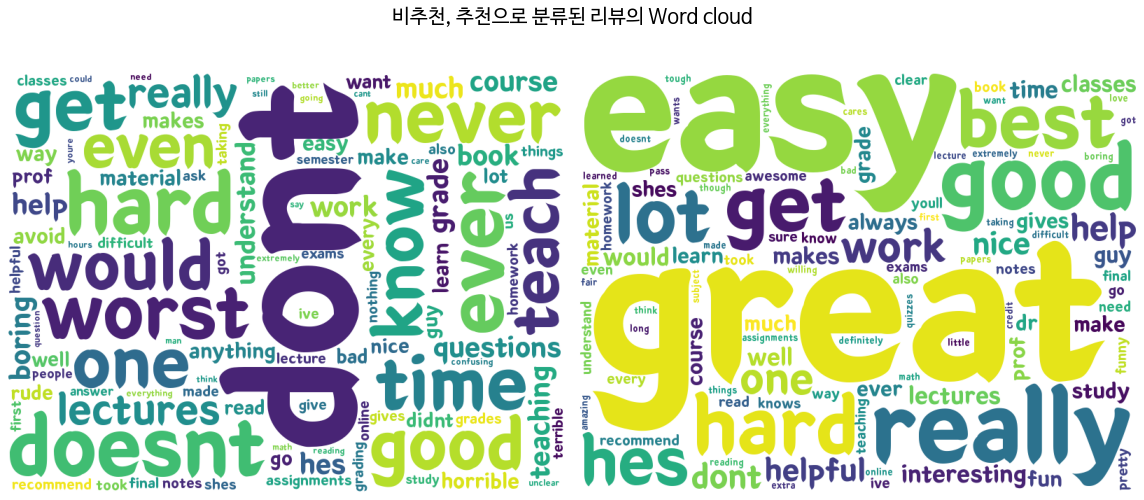

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

clouds = [cloud, cloud1]

for i in range(len(clouds)):
    ax = axes[i]
    ax.axis('off')
    ax.imshow(clouds[i])

plt.suptitle('비추천, 추천으로 분류된 리뷰의 Word cloud', fontsize=20)
plt.tight_layout()
plt.show()

In [40]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    result = ''
    for w in w_tokenizer.tokenize(text):
        result = result + lemmatizer.lemmatize(w) + ' '
    return result

new_df['comments'] = new_df['comments'].apply(lemmatize)

In [41]:
new_df['comments'][:5].values

array(['hard twoinone gened knockout content stimulating unlike class actually participate pas section easy offer extra credit every week funny dude much say ',
       'definitely going choose prof looney interesting easy bring note exam dont need remember lot lot bonus point available observatory session awesome ',
       'overall enjoyed assignment straightforward interesting didnt enjoy video project felt one group cared enough help ',
       'yes possible get youll definitely work content pretty interesting tog get super organized youll multiple thing due every week ton lecture go possible id avoid week course youll definitely always somethingto ',
       'looney great knowledge astronomy explain super easy way elementary taught great passion great illustration definitely fun interested knowledge wont cover dont hesitate ask great '],
      dtype=object)

## 지도 학습 기반의 분류

다양한 **Classifier**와 **Tfidf Vectorizer**를 활용한 **Pipeline** 생성과 **Hyper parameter tuning**

### Baseline hyper parameter tuning

In [43]:
X = new_df['comments']
y = new_df['recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1214)

`Classifier` 파라미터만 설정해주고 `GridSearchCV`를 수행해 보겠습니다

In [48]:
pipe_naive = Pipeline([('vectorizer', TfidfVectorizer()),
                       ('classifier', BernoulliNB())])

pipe_svc = Pipeline([('vectorizer', TfidfVectorizer()),       
                     ('classifier', SVC())])

pipe_lr = Pipeline([('vectorizer', TfidfVectorizer()),
                    ('classifier', LogisticRegression())])

models = [pipe_naive, pipe_svc, pipe_lr]


params_naive = [{'classifier__alpha': [0.01, 1.0, 10.0],
                 'classifier__fit_prior': [True, False]}]

params_svc = [{'classifier__C': [100, 1, 0.01],
               'classifier__kernel': ['rbf', 'poly'],
               'classifier__gamma': [0.001, 1, 10]}]

params_lr = [{'classifier__penalty':['l2', 'l1'],
              'classifier__C':[0.01, 1, 10]}]


params = [params_naive, params_svc, params_lr]

In [49]:
class_names = ['Not recommended','Recommended']
plt.figure(figsize=(20, 12))

def runclassifiers(X_train, y_train, X_test, y_test):

    # 총 3 x 2, 6개의 그래프를 생성
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20, 15))

    # 각 평가 지표를 저장할 변수들 생성
    result_name = []
    result_summary1 = []
    result_recall_recommended = []
    result_recall_not_recommended = []
    result_acc_score = []
    result_best_score = []

    for model, param in zip(models, params):

        name = str(model)
        if 'BernoulliNB' in name:
          name = 'BernoulliNB'
        elif 'SVC' in name:
          name = 'SVC'
        elif 'LogisticRegression' in name:
          name = 'LogisticRegression'
        """
        최적 파라미터 탐색
        """
        # GridSearchCV 생성하여 fitting (cv=5)
        gscv = GridSearchCV(estimator=model, param_grid=param, scoring = 'recall_micro', cv=5)   
        gscv.fit(X_train, y_train)
        # 가장 좋은 성능 지표를 저장한다
        msg = gscv.best_estimator_
        msg1 = str(gscv.best_estimator_)
        result_summary1.append(msg1)
        result_name.append(name)
        
        # 베스트 모델로 predict
        y_pred = gscv.predict(X_test)

        """
        모델 평가
        """
        ascore = gscv.best_estimator_.score(X_test, y_test)
             
        # Recall 적용
        recall_recommended = recall_score(y_test, y_pred, average='binary', pos_label=1)

        # Recall 적용
        recall_not_recommended = recall_score(y_test, y_pred, average='binary', pos_label=0)

        
        # Accuracy score 적용
        acc = accuracy_score(y_test, y_pred)

        msg2 = f'{name}\nAccuracy score: {acc:.4f}\n"Recommended" recall: {recall_recommended:.4f}\n"Not recommended" recall: {recall_not_recommended:.4f}'
        print(msg2)
        print('='*60)

        result_recall_not_recommended.append(recall_not_recommended)
        result_recall_recommended.append(recall_recommended)
        result_acc_score.append(acc)
        result_best_score.append(ascore)


        if name == 'BernoulliNB':
          ax = axes[0, 0]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names)
          ax.set_title('Naive Bayes')
          ax = axes[0, 1]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          ax.set_title('Naive Bayes (normalized)')
        elif name == 'SVC':
          ax = axes[1, 0]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names)
          ax.set_title('SVC')
          ax = axes[1, 1]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          ax.set_title('SVC (normalized)')
        elif name == 'LogisticRegression':
          ax = axes[2, 0]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names)
          ax.set_title('Logistic Regression')
          ax = axes[2, 1]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          ax.set_title('Logistic Regression (normalized)')
    
    fig.tight_layout()
    plt.show()

    base_line_result_summary_list = pd.DataFrame({'name': result_name,
                                        'best_estimator': result_summary1,
                                        '"Not recommended" recall': result_recall_not_recommended,
                                        '"Recommended" recall': result_recall_recommended,
                                        'Accuracy score': result_acc_score,
                                        'Best score': result_best_score})
    return base_line_result_summary_list

<Figure size 1440x864 with 0 Axes>

BernoulliNB
Accuracy score: 0.8540
"Recommended" recall: 0.9389
"Not recommended" recall: 0.5748
SVC
Accuracy score: 0.8676
"Recommended" recall: 0.9474
"Not recommended" recall: 0.6056
LogisticRegression
Accuracy score: 0.8610
"Recommended" recall: 0.9618
"Not recommended" recall: 0.5297


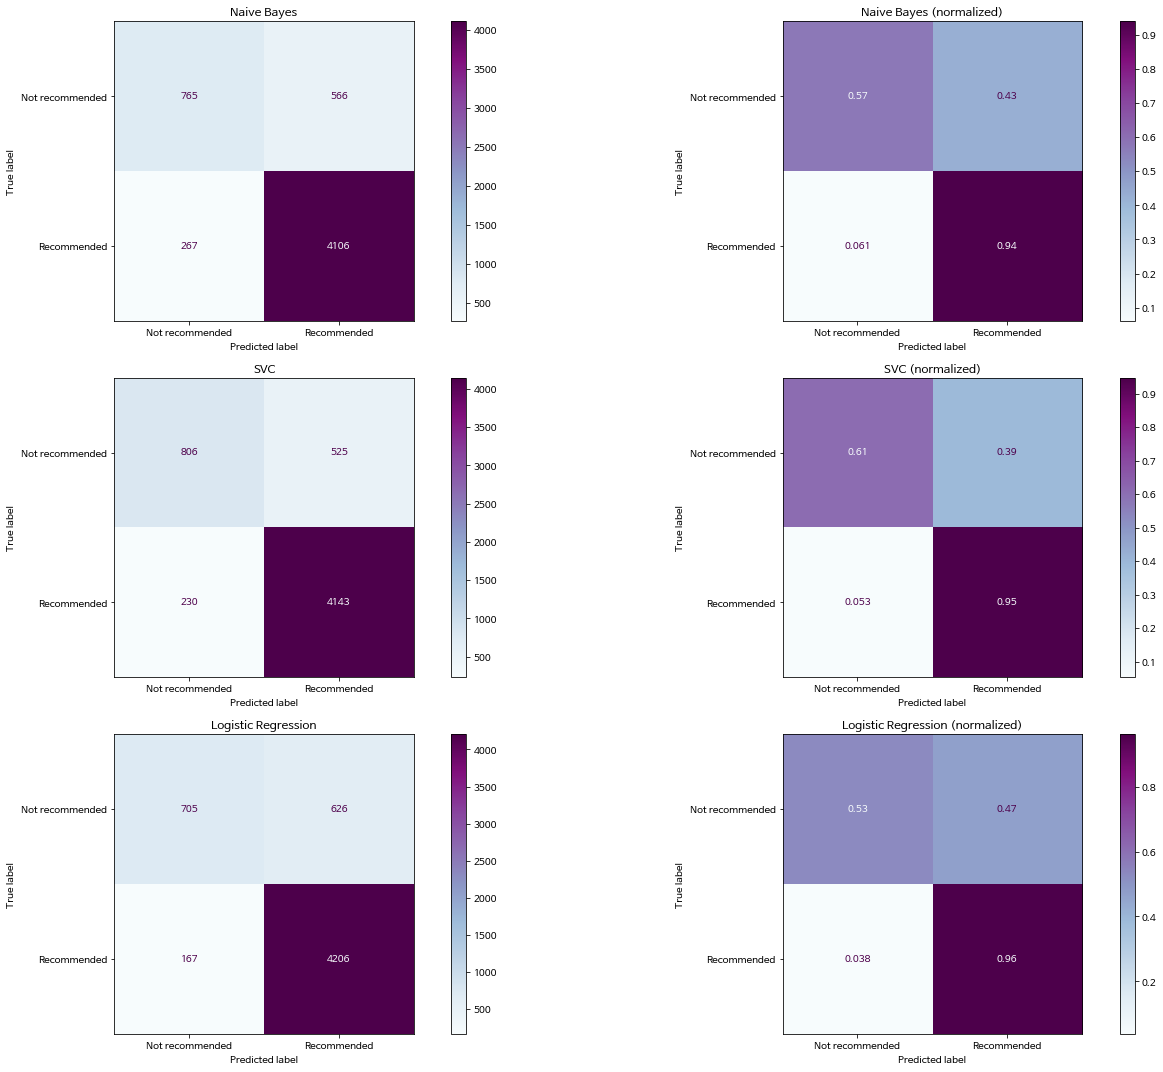

In [50]:
base_line_result_summary_list = runclassifiers(X_train, y_train, X_test, y_test)

In [51]:
base_line_result_summary_list.sort_values(by=['"Not recommended" recall', 'Accuracy score'], ascending=[False,False])

,name,best_estimator,"""Not recommended"" recall","""Recommended"" recall",Accuracy score,Best score
1,SVC,"Pipeline(steps=[('vectorizer', TfidfVectorizer...",0.605560,0.947405,0.867637,0.867637
0,BernoulliNB,"Pipeline(steps=[('vectorizer', TfidfVectorizer...",0.574756,0.938944,0.853962,0.853962
2,LogisticRegression,"Pipeline(steps=[('vectorizer', TfidfVectorizer...",0.529677,0.961811,0.860975,0.860975


`Accuracy`가 높은 상태에서 얼마나 각각의 `Recall` 값이 균형 있게 높은지를 평가지표로 삼으면, `SVC` 모델이 가장 우수한 성능을 보였습니다.

### TFIDF x Classifier Hyper parameter tuning

이번에는 `Tfidf Vectorizer` 파라미터를 설정해주고 모델 하이퍼 파라미터 튜닝을 진행해보겠습니다.

In [44]:
pipe_naive = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000, min_df=100, sublinear_tf=True, ngram_range = (1, 2))),
                       ('classifier', BernoulliNB())])

pipe_svc = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000, min_df=100, sublinear_tf=True, ngram_range = (1, 2))),       
                     ('classifier', SVC())])

pipe_lr = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000, min_df=100, sublinear_tf=True, ngram_range = (1, 2))),
                    ('classifier', LogisticRegression())])

models = [pipe_naive, pipe_svc, pipe_lr]


params_naive = [{'classifier__alpha': [0.01, 1.0, 10.0],
                 'classifier__fit_prior': [True, False]}]

params_svc = [{'classifier__C': [100, 1, 0.01],
               'classifier__kernel': ['rbf', 'poly'],
               'classifier__gamma': [0.001, 1, 10]}]

params_lr = [{'classifier__penalty':['l2', 'l1'],
              'classifier__C':[0.01, 1, 10]}]


params = [params_naive, params_svc, params_lr]

In [45]:
class_names = ['Not recommended','Recommended']
plt.figure(figsize=(20, 12))

def runclassifiers(X_train, y_train, X_test, y_test):

    # 총 3 x 2, 6개의 그래프를 생성
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20, 15))

    # 각 평가 지표를 저장할 변수들 생성
    result_name = []
    result_summary1 = []
    result_recall_recommended = []
    result_recall_not_recommended = []
    result_acc_score = []
    result_best_score = []

    for model, param in zip(models, params):

        name = str(model)
        if 'BernoulliNB' in name:
          name = 'BernoulliNB'
        elif 'SVC' in name:
          name = 'SVC'
        elif 'LogisticRegression' in name:
          name = 'LogisticRegression'
        """
        최적 파라미터 탐색
        """
        # GridSearchCV 생성하여 fitting (cv=5)
        gscv = GridSearchCV(estimator=model, param_grid=param, scoring = 'recall_micro', cv=5)   
        gscv.fit(X_train, y_train)
        # 가장 좋은 성능 지표를 저장한다
        msg = gscv.best_estimator_
        msg1 = str(gscv.best_estimator_)
        result_summary1.append(msg1)
        result_name.append(name)
        
        # 베스트 모델로 predict
        y_pred = gscv.predict(X_test)

        """
        모델 평가
        """
        ascore = gscv.best_estimator_.score(X_test, y_test)
             
        # Recall 적용
        recall_recommended = recall_score(y_test, y_pred, average='binary', pos_label=1)

        # Recall 적용
        recall_not_recommended = recall_score(y_test, y_pred, average='binary', pos_label=0)

        
        # Accuracy score 적용
        acc = accuracy_score(y_test, y_pred)

        msg2 = f'{name}\nAccuracy score: {acc:.4f}\n"Recommended" recall: {recall_recommended:.4f}\n"Not recommended" recall: {recall_not_recommended:.4f}'
        print(msg2)
        print('='*60)

        result_recall_not_recommended.append(recall_not_recommended)
        result_recall_recommended.append(recall_recommended)
        result_acc_score.append(acc)
        result_best_score.append(ascore)


        if name == 'BernoulliNB':
          ax = axes[0, 0]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names)
          ax.set_title('Naive Bayes')
          ax = axes[0, 1]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          ax.set_title('Naive Bayes (normalized)')
        elif name == 'SVC':
          ax = axes[1, 0]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names)
          ax.set_title('SVC')
          ax = axes[1, 1]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          ax.set_title('SVC (normalized)')
        elif name == 'LogisticRegression':
          ax = axes[2, 0]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names)
          ax.set_title('Logistic Regression')
          ax = axes[2, 1]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          ax.set_title('Logistic Regression (normalized)')
    
    fig.tight_layout()
    plt.show()

    result_summary_list = pd.DataFrame({'name': result_name,
                                        'best_estimator': result_summary1,
                                        '"Not recommended" recall': result_recall_not_recommended,
                                        '"Recommended" recall': result_recall_recommended,
                                        'Accuracy score': result_acc_score,
                                        'Best score': result_best_score})
    return result_summary_list

<Figure size 1440x864 with 0 Axes>

BernoulliNB
Accuracy score: 0.8468
"Recommended" recall: 0.9067
"Not recommended" recall: 0.6499
SVC
Accuracy score: 0.8517
"Recommended" recall: 0.9572
"Not recommended" recall: 0.5049
LogisticRegression
Accuracy score: 0.8492
"Recommended" recall: 0.9351
"Not recommended" recall: 0.5672


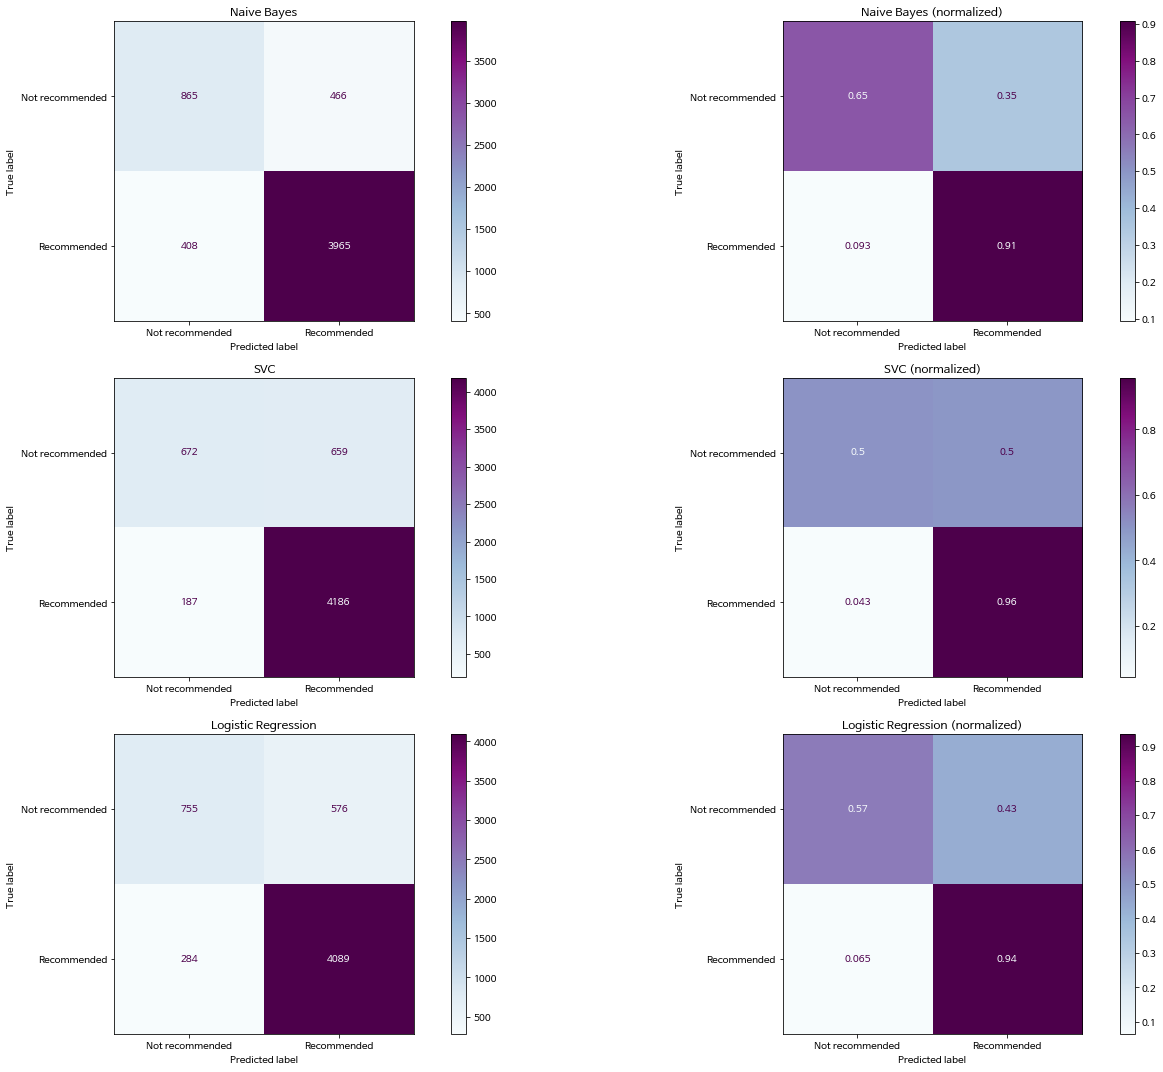

In [46]:
result_summary_list = runclassifiers(X_train, y_train, X_test, y_test)

In [58]:
result_summary_list.sort_values(by=['"Not recommended" recall', 'Accuracy score'], ascending=[False,False])

,name,best_estimator,"""Not recommended"" recall","""Recommended"" recall",Accuracy score,Best score
0,BernoulliNB,"Pipeline(steps=[('vectorizer',\n ...",0.649887,0.906700,0.846774,0.846774
2,LogisticRegression,"Pipeline(steps=[('vectorizer',\n ...",0.567243,0.935056,0.849229,0.849229
1,SVC,"Pipeline(steps=[('vectorizer',\n ...",0.504884,0.957238,0.851683,0.851683


In [60]:
X = new_df['comments']
y = new_df['recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1214)

In [70]:
tfidfv = TfidfVectorizer(max_features=2000, min_df=100, sublinear_tf=True, ngram_range = (1, 2))
tfidfv.fit(X_train)

train_matrix = tfidfv.transform(X_train)
test_matrix = tfidfv.transform(X_test)

naive_bayes = BernoulliNB()
naive_bayes.fit(train_matrix, y_train)

test_pred = naive_bayes.predict(test_matrix)

final_recall_recommended = recall_score(y_test, test_pred, average='binary', pos_label=1)
final_recall_not_recommended = recall_score(y_test, test_pred, average='binary', pos_label=0)
final_accuracy = accuracy_score(y_test, test_pred)

In [71]:
print(f'"Recommended" recall score: {final_recall_recommended:.4f}')
print(f'"Not recommended" recall score: {final_recall_not_recommended:.4f}')
print(f'Accuracy score: {final_accuracy:.4f}')

"Recommended" recall score: 0.9067
"Not recommended" recall score: 0.6499
Accuracy score: 0.8468


`TFIDF` 파라미터를 설정해준 상태로 하이퍼 파라미터 튜닝을 하면 나이브 베이즈 모델의 `BernoulliNB classifier`가 가장 우수한 성능을 보였습니다.

## 감성 어휘 사전을 이용한 분류

이번엔 `nltk`에서 제공하는 `SentiWordNet`을 활용해 분류를 시도해보겠습니다.

해당 패키지를 활용하면 문장을 `단어 단위로 토큰화`한 뒤 품사를 `태깅`해줍니다.

`품사가 태깅된 단어`를 기반으로 긍정 / 부정 지수를 구하고 이를 합산해 `특정 threshold`를 기준으로 최종적인 긍정 / 부정으로 분류를 해줍니다.

In [64]:
senti = SentimentIntensityAnalyzer()

senti_score = senti.polarity_scores(X_train.iloc[0])
senti_score

{'neg': 0.0, 'neu': 0.386, 'pos': 0.614, 'compound': 0.9136}

In [65]:
def vader_sentiment(comments, threshold):
  senti = SentimentIntensityAnalyzer()
  score = senti.polarity_scores(comments)

  sentiment = score['compound']
  recommended = 1 if sentiment >= threshold else 0
  return recommended

In [66]:
new_df['predicted'] = new_df['comments'].apply(lambda x: vader_sentiment(x, 0.1))

y_true = new_df['recommended'].values
y_pred = new_df['predicted'].values

In [72]:
recall_recommended = recall_score(y_true, y_pred, average='binary', pos_label=1)
recall_not_recommended = recall_score(y_true, y_pred, average='binary', pos_label=0)
vader_accuracy = accuracy_score(y_true, y_pred)

In [73]:
print(f'"Recommended" recall score: {recall_recommended:.4f}')
print(f'"Not recommended" recall score: {recall_not_recommended:.4f}')
print(f'Accuracy score: {vader_accuracy:.4f}')

"Recommended" recall score: 0.8679
"Not recommended" recall score: 0.6507
Accuracy score: 0.8172


In [75]:
print('Naive Bayes classifier evaluation')
print('='*50)
print(f'"Recommended" recall score: {final_recall_recommended:.4f}')
print(f'"Not recommended" recall score: {final_recall_not_recommended:.4f}')
print(f'Accuracy score: {final_accuracy:.4f}\n')

print('SentiWordNet evalutaion')
print('='*50)
print(f'"Recommended" recall score: {recall_recommended:.4f}')
print(f'"Not recommended" recall score: {recall_not_recommended:.4f}')
print(f'Accuracy score: {vader_accuracy:.4f}')

Naive Bayes classifier evaluation
"Recommended" recall score: 0.9067
"Not recommended" recall score: 0.6499
Accuracy score: 0.8468

SentiWordNet evalutaion
"Recommended" recall score: 0.8679
"Not recommended" recall score: 0.6507
Accuracy score: 0.8172


`BernoulliNB` 로 학습한 모델의 정확도가 상대적으로 더 높습니다.

> Threshold를 조정해보겠습니다

In [76]:
new_df['predicted'] = new_df['comments'].apply(lambda x: vader_sentiment(x, 0.2))

y_true = new_df['recommended'].values
y_pred = new_df['predicted'].values

In [77]:
recall_recommended = recall_score(y_true, y_pred, average='binary', pos_label=1)
recall_not_recommended = recall_score(y_true, y_pred, average='binary', pos_label=0)
vader_accuracy = accuracy_score(y_true, y_pred)

print(f'"Recommended" recall score: {recall_recommended:.4f}')
print(f'"Not recommended" recall score: {recall_not_recommended:.4f}')
print(f'Accuracy score: {vader_accuracy:.4f}')

"Recommended" recall score: 0.8508
"Not recommended" recall score: 0.6886
Accuracy score: 0.8129


`Recommended`의 recall score가 조금 낮아진 대신 `Not recommended`의 recall score가 조금 높아졌습니다.

In [78]:
for threshold in [0.3, 0.5, 0.7]:
  new_df['predicted'] = new_df['comments'].apply(lambda x: vader_sentiment(x, threshold))
  y_true = new_df['recommended'].values
  y_pred = new_df['predicted'].values
  recall_recommended = recall_score(y_true, y_pred, average='binary', pos_label=1)
  recall_not_recommended = recall_score(y_true, y_pred, average='binary', pos_label=0)
  vader_accuracy = accuracy_score(y_true, y_pred)

  print(f'Threshold {threshold} 일 때 평가지표')
  print('=' * 50)
  print(f'"Recommended" recall score: {recall_recommended:.4f}')
  print(f'"Not recommended" recall score: {recall_not_recommended:.4f}')
  print(f'Accuracy score: {vader_accuracy:.4f}')

Threshold 0.3 일 때 평가지표
"Recommended" recall score: 0.8264
"Not recommended" recall score: 0.7265
Accuracy score: 0.8031
Threshold 0.5 일 때 평가지표
"Recommended" recall score: 0.7402
"Not recommended" recall score: 0.8197
Accuracy score: 0.7588
Threshold 0.7 일 때 평가지표
"Recommended" recall score: 0.5937
"Not recommended" recall score: 0.9038
Accuracy score: 0.6661


임계값을 조정하면 **비추천에 대한 recall score**가 올라가는 대신 정확도가 많이 떨어짐을 알 수 있습니다.

사실 이 수치는 **추천으로 분류할 게시물**이 임계값 조정에 의해 **비추천으로 옮겨간 것**이기 때문에

 모델 자체가 비추천 강좌를 더 잘 분류해낸다고 할 수 없습니다.

## New input test

`Classifier` 모델 중 가장 좋은 성능을 냈던 `BernoulliNB classifier` 모델을 활용하여 새 input을 토대로 **추천/ 비추천** 을 예측하는 함수를 생성해보겠습니다.

In [79]:
joblib.dump(naive_bayes, 'best_model.pkl')

['best_model.pkl']

In [81]:
joblib.dump(tfidfv, 'tfidfv.pkl')

['tfidfv.pkl']

In [82]:
loaded_model = joblib.load('best_model.pkl')
loaded_tfidfv = joblib.load('tfidfv.pkl')

In [83]:
def predict(comment):
  comment = re.sub(r'[^a-zA-Z\s]', '', comment).lower().split()
  comment = [' '.join([word for word in comment if word not in (stop_words)])]
  comment = list(map(lemmatize, comment))
  comment = loaded_tfidfv.transform(comment)
  result = loaded_model.predict(comment)
  predict_proba = loaded_model.predict_proba(comment)

  if predict_proba[0][0] > predict_proba[0][1]:
    return f'{predict_proba[0][0]*100:.2f} % 의 확률로 해당 강좌를 비추천하는 코멘트입니다.'
  elif predict_proba[0][0] < predict_proba[0][1]:
    return f'{predict_proba[0][1]*100:.2f} % 의 확률로 해당 강좌를 추천하는 코멘트입니다.'

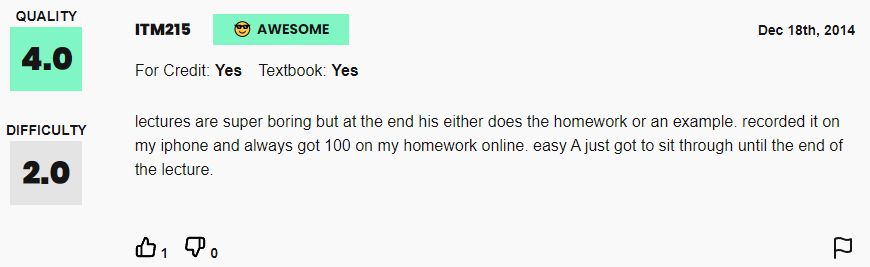

In [84]:
predict("lectures are super boring but at the end his either does the homework or an example. recorded it on my iphone and always got 100 on my homework online. easy A just got to sit through until the end of the lecture.")

'89.69 % 의 확률로 해당 강좌를 추천하는 코멘트입니다.'

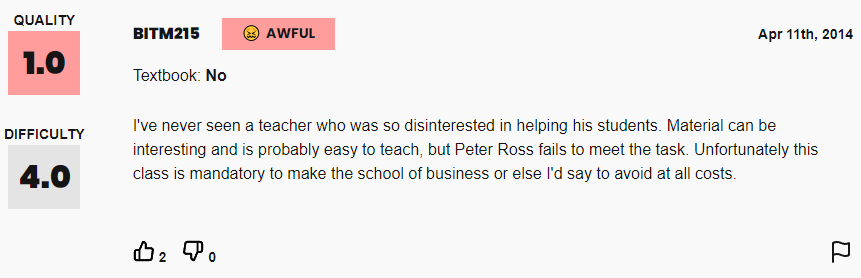

In [85]:
predict("I've never seen a teacher who was so disinterested in helping his students. Material can be interesting and is probably easy to teach, but Peter Ross fails to meet the task. Unfortunately this class is mandatory to make the school of business or else I'd say to avoid at all costs.")

'96.58 % 의 확률로 해당 강좌를 비추천하는 코멘트입니다.'

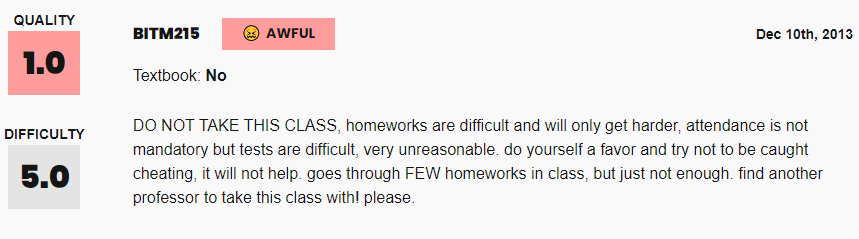

In [86]:
predict("DO NOT TAKE THIS CLASS, homeworks are difficult and will only get harder, attendance is not mandatory but tests are difficult, very unreasonable. do yourself a favor and try not to be caught cheating, it will not help. goes through FEW homeworks in class, but just not enough. find another professor to take this class with! please")

'59.37 % 의 확률로 해당 강좌를 비추천하는 코멘트입니다.'

## **결론 및 후기**

지난 [프로젝트](https://linkhere)에서 수치형 데이터로만 추천 /비추천을 분류한 **confusion matrix**는 다음과 같습니다.

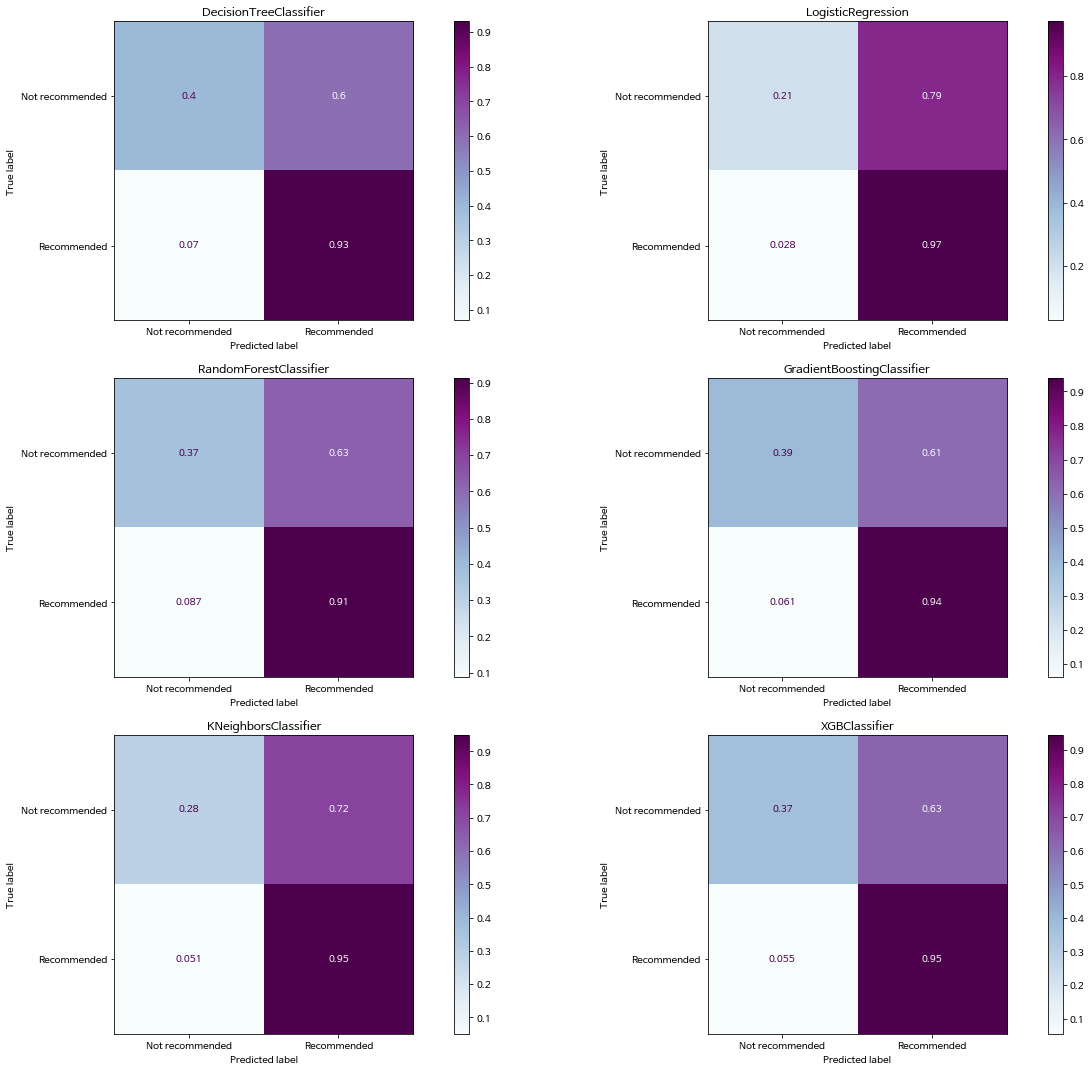

다음 **confusion matrix**는 `comment` feature를 활용해 `tfidf x classifier`를 적용시킨 결과입니다.

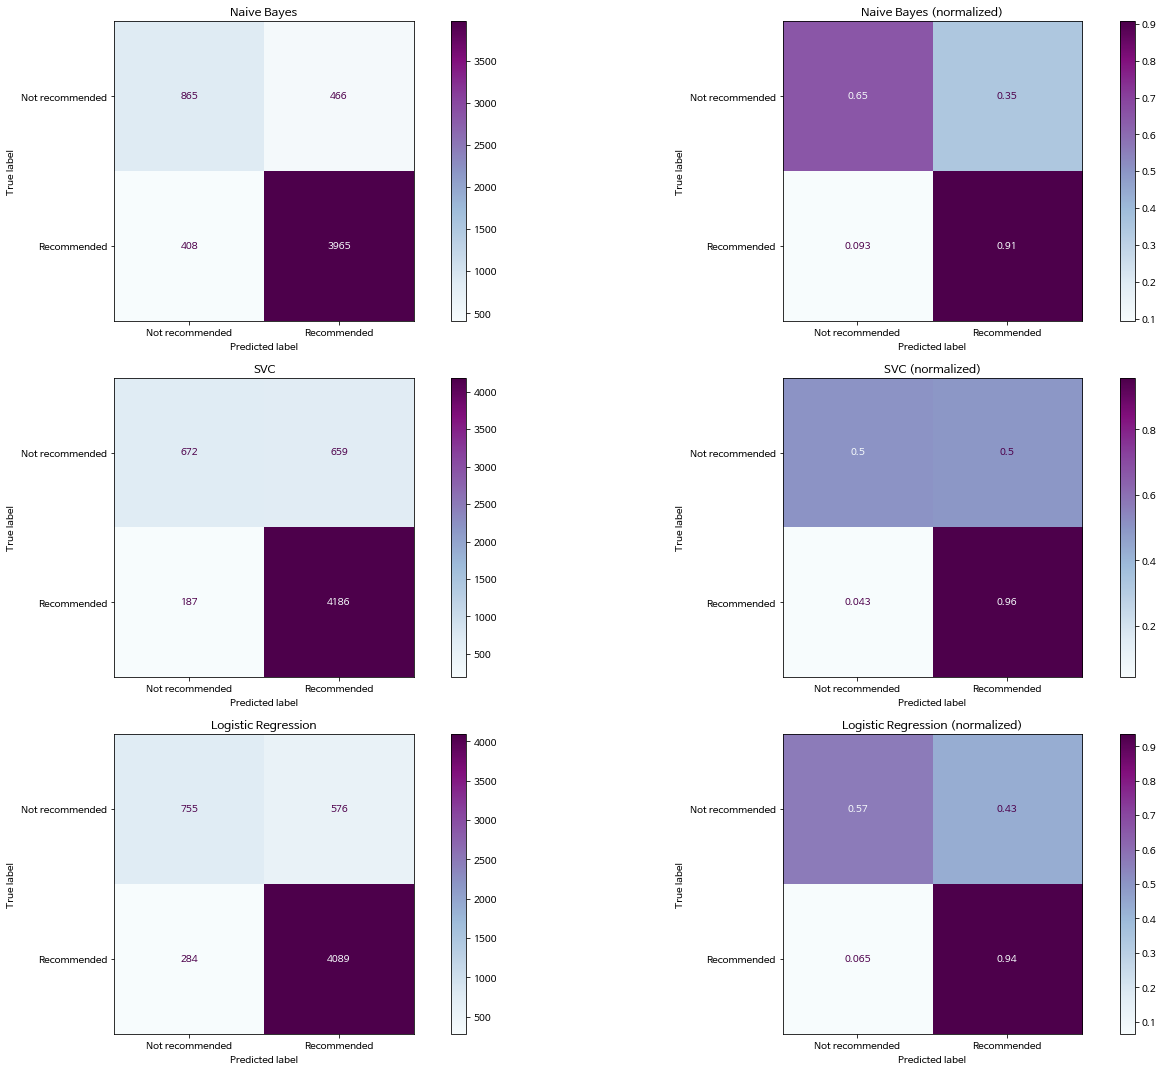

지난 프로젝트와 이번 프로젝트를 바탕으로 알 수 있었던 점은,

30개 정도 되는 수치형 데이터들을 분석해 두 라벨을 분류하는 모델보다 `Tf-idf Vectorizer`를 활용해 텍스트 데이터 내에서 각 단어의 중요도를 분석해 두 라벨을 분류하는 것이 상대적으로 더 정확했다는 점입니다.

**강좌의 추천/ 비추천**을 결정짓는 요소 중 `수치형 데이터`들의 영향력보다 `comment` feature 하나의 영향력이 더 크다는 점을 알 수 있었습니다.

**아쉬운 점**

---

런타임 제한시간을 더 많이 확보했다면 하이퍼 파라미터 튜닝 과정에서

`Tfidf vectorizer`와 `Classifier`를 동시에 조절하여 더 이상적인 모델을 얻을 수 있었겠지만 로컬 환경의 제한으로 그렇지 못한 점이 아쉽습니다.


**감사합니다!**